In [1]:
import pandas as pd
import os
import csv
from matplotlib import pyplot as plt
import torch
import torch.utils.data as Data
from torch.nn import LSTM,Module,Linear
import torch.nn.functional as F

In [2]:
f=open("Dataset/GOOGL.csv",encoding='utf-8')
dataframe=pd.read_csv(f)
f.close()
print(type(dataframe))
dataframe.head(15)

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602
5,2004-08-26,52.527527,54.029030,52.382381,54.009010,54.009010,7094898
6,2004-08-27,54.104103,54.364365,52.897900,53.128128,53.128128,6211782
7,2004-08-30,52.692692,52.797798,51.056057,51.056057,51.056057,5196798
8,2004-08-31,51.201202,51.906906,51.131130,51.236237,51.236237,4917877
9,2004-09-01,51.401402,51.536537,49.884884,50.175175,50.175175,9138253


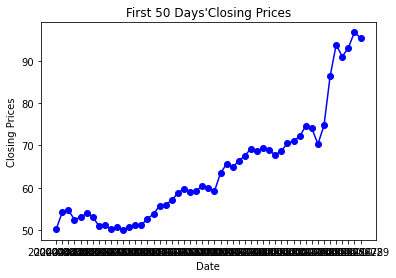

In [3]:
xdata=dataframe.loc[:50,"Date"]
ydata=dataframe.loc[:50,"Close"]
plt.plot(xdata,ydata,color='b',marker='o')
plt.title("First 50 Days'Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Prices")
plt.show()

In [4]:
# previous 200 days' prices
dataX=[]
#label: future 5 days' prices
dataY=[]
dayCount=0
tempX=[] #save the previous 200 days' prices for the current date
tempY=[] #save the future 5 days' prices for the current date
for index, rows in dataframe.iterrows():
    if dayCount<200:
        dayCount+=1
        tempX.append([rows['Open'],rows['High'],rows['Low'],rows['Close']])
        continue
    if dayCount<205:
        dayCount+=1
        tempY.append([rows['Open'],rows['High'],rows['Low'],rows['Close']])
        continue
    dataX.append(tempX[:])
    dataY.append(tempY[:])
    
    # when dayCount>205:
    # move forward the sliding window by 1 day (there will always be 205 days in the sliding window)
    # Note: the first element in tempY, which is tempY[:1], is the following row of the last row in tempX.
    tempX=tempX[1:]+tempY[:1]
    tempY=tempY[1:]
    tempY.append([rows['Open'],rows['High'],rows['Low'],rows['Close']])
# Append the last data
dataX.append(tempX[:])
dataY.append(tempY[:])

In [5]:
# Seperate the dataset into a training dataset and a testing dataset
dataX=torch.tensor(dataX)
dataY=torch.tensor(dataY)

dataset=Data.TensorDataset(dataX,dataY)
train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size
train_dataset,test_dataset=torch.utils.data.random_split(dataset,[train_size,test_size])

train_loader=Data.DataLoader(dataset=train_dataset,batch_size=64,shuffle=True)
test_loader=Data.DataLoader(dataset=test_dataset,batch_size=64,shuffle=True)

In [14]:
# Build the LSTM model:
class myLSTM(Module):
    def __init__(self):
        super(myLSTM,self).__init__()
        self.lstm=LSTM(
            input_size=4,
            hidden_size=4,
            num_layers=2,
            batch_first=True)
        self.linear=Linear(800,20)
    def forward(self,x):
        return self.linear(self.lstm(x)[0].reshape(-1,800))

In [21]:
# Training process
model=myLSTM()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
trainingLoss=[]
testingLoss=[]
trainingAcc=[]
testingAcc=[]

for epoch in range(100):
    currentLoss=[] # store the loss of each mini-batch in the train_loader
    currentAcc=[]
    model.train()
    for index,(X,Y) in enumerate(train_loader):
        out=model(X)
        loss=F.mse_loss(out,Y.view(-1,20)) #flatten the Y while calculating the loss
        currentAccuracy=out.div(Y.view(-1,20))
        if(currentAccuracy.mean().item()>1):
            currentAccuracy=1/currentAccuracy.mean().item()
        else:
            currentAccuracy=currentAccuracy.mean().item()
        currentAcc.append(100*currentAccuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        currentLoss.append(loss.item())
    # take the average of the mini-batches' losses, and store it into the trainingLoss
    trainingLoss.append(sum(currentLoss)/len(currentLoss))
    trainingAcc.append(sum(currentAcc)/len(currentAcc))
    
    
    currentLossTest=[]
    currentAccTest=[]
    model.eval()
    for index, (X,Y) in enumerate(test_loader):
        out=model(X)
        loss=F.mse_loss(out,Y.view(-1,20))
        currentLossTest.append(loss.item())
        currentAccuracy=out.div(Y.view(-1,20))
        if(currentAccuracy.mean().item()>1):
            currentAccuracy=1/currentAccuracy.mean().item()
        else:
            currentAccuracy=currentAccuracy.mean().item()
        currentAccTest.append(100*currentAccuracy)
    testingLoss.append(sum(currentLossTest)/len(currentLossTest))
    testingAcc.append(sum(currentAccTest)/len(currentAccTest))
    
    print("Epoch: ",epoch, " Average Testing Acc: ",testingAcc[-1])

Epoch:  0  Average Testing Acc:  3.057426187608923
Epoch:  1  Average Testing Acc:  14.852231315204076
Epoch:  2  Average Testing Acc:  32.893129757472444
Epoch:  3  Average Testing Acc:  51.32733051265989
Epoch:  4  Average Testing Acc:  64.66269791126251
Epoch:  5  Average Testing Acc:  76.93893696580615
Epoch:  6  Average Testing Acc:  88.34740175747821
Epoch:  7  Average Testing Acc:  92.13470140914967
Epoch:  8  Average Testing Acc:  93.38693409398782
Epoch:  9  Average Testing Acc:  86.37083398353005
Epoch:  10  Average Testing Acc:  82.07901080025692
Epoch:  11  Average Testing Acc:  78.00672782989038
Epoch:  12  Average Testing Acc:  75.1026133216457
Epoch:  13  Average Testing Acc:  71.30252172311637
Epoch:  14  Average Testing Acc:  68.17339907959303
Epoch:  15  Average Testing Acc:  66.27262617287589
Epoch:  16  Average Testing Acc:  65.11376673631229
Epoch:  17  Average Testing Acc:  63.54207526969848
Epoch:  18  Average Testing Acc:  62.615015084727794
Epoch:  19  Average 

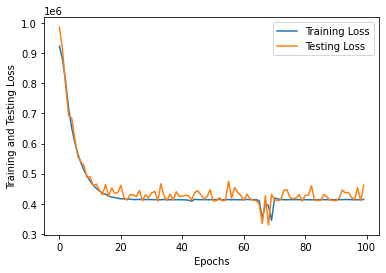

In [26]:
# Check when the Mean-Square loss converges
plt.plot(list(range(100)),trainingLoss,label="Training Loss")
plt.plot(list(range(100)),testingLoss,label="Testing Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training and Testing Loss")
plt.show()

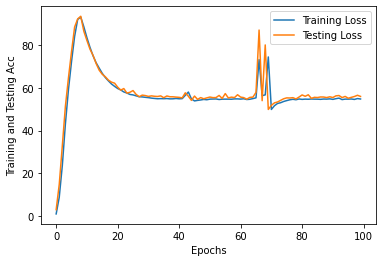

In [28]:
# Check when the Train & Test Acc converges
plt.plot(list(range(100)),trainingAcc,label="Training Loss")
plt.plot(list(range(100)),testingAcc,label="Testing Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training and Testing Acc")
plt.show()